# LSTM

In [21]:
import keras
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

Cleaned data is loaded in and mapped with respective name of weekday. BUSGADEHUSET parking lot space is also inspected as it consistantly goes above capacity. Changed to actual value of 150 from 130 spaces avaiable. Capacity is still above 1.0 and is removed due to overfitting the predicted values.

In [28]:
# Loads the data
data = pd.read_csv('parking_data_cleaned.csv')

# Convert 'weekday' to 'weekday_name via mapping
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
data['weekday_name'] = data['weekday'].map(weekday_map)

# sets 'update_dt' to datetime format
data['update_dt'] = pd.to_datetime(data['update_dt'])

# Extracts the hour of day and create a new column
data['hour_of_day'] = data['update_dt'].dt.hour

# Change total spaces for BUSGADEHUSET to 150
data.loc[data['garagecode'] == 'BUSGADEHUSET', 'totalspaces'] = 150
mask = data['garagecode'] == 'BUSGADEHUSET'
data.loc[mask, 'capacity'] = data.loc[mask, 'vehiclecount'] / data.loc[mask, 'totalspaces']
data.head()

,vehiclecount,totalspaces,garagecode,update_dt,date,time,weekday,day,month,year,...,weekday_cos,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos,capacity,weekday_name,hour_of_day
0,869,1240,SCANDCENTER,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,...,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.700806,Thursday,9
1,22,953,BRUUNS,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,...,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.023085,Thursday,9
2,124,150,BUSGADEHUSET,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,...,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.826667,Thursday,9
3,106,400,MAGASIN,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,...,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.265000,Thursday,9
4,115,210,KALKVAERKSVEJ,2014-05-22 09:09:04.145,2014-05-22,09:09:04.145000,3,22,5,2014,...,-0.900969,0.5,-0.866025,-0.968077,-0.250653,0.678801,-0.734323,0.547619,Thursday,9


In [29]:
# Filters the dataframe for rows where the garagecode is 'BUSGADEHUSET'
busgadehuset_df = data[data['garagecode'] == 'BUSGADEHUSET']
busgadehuset_capacity = busgadehuset_df['capacity']

# Prints out values of BUSGADEHUSET to see if above 1.0
print(busgadehuset_capacity)

#removes data for BUSGADEHUSET due to data skew
data = data[data['garagecode'] != 'BUSGADEHUSET']

2        0.826667
8        0.826667
14       0.833333
20       0.960000
26       1.100000
           ...   
46586    0.886667
46593    1.013333
46600    1.006667
46607    0.986667
46614    0.973333
Name: capacity, Length: 6908, dtype: float64


In [30]:
# One-hot encode 'weekday_name' and 'garagecode' for numerical values
data = pd.get_dummies(data, columns=['weekday_name', 'garagecode'])

# Selected features for testing are placed in a list and transformed
numerical_features = ['vehiclecount', 'totalspaces', 'weekday_cos', 'weekday_sin', 'time_sin', 'time_cos']
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# data split into training and testing without shifting values.
split_point = int(len(data) * 0.8)
train_df = data.iloc[:split_point].copy()
test_df = data.iloc[split_point:].copy()

In [31]:
# Function creates sequences 
def create_sequences(df, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(df)):
        seq = df.iloc[i-sequence_length:i].drop(['capacity', 'update_dt', 'date', 'time', 'weekday', 'day', 'month', 'year'], axis=1, errors='ignore')  # Exclude datetime columns
        X.append(seq.values)
        y.append(df.iloc[i]['capacity'])
    return np.array(X), np.array(y)

# Assuming preprocessing has been applied to train_df and test_df
sequence_length = 7  # 7 is chosen for 7 days in a week

# train_df and test_df datasets are given sequences and split respectively
X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)

# reshaped both Xs to be in the form [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], sequence_length, -1))
X_test = X_test.reshape((X_test.shape[0], sequence_length, -1))

# train_df is split down further to be fed into model 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.2)

#change types to float32 for LSTM
X_train1 = X_train1.astype('float32')
y_train1 = y_train1.astype('float32')

In [32]:
model_path = 'LSTM_model1.h5'

model = Sequential()

# Input LSTM layer
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train1.shape[1], X_train1.shape[2])))
# Adding return_sequences=True to allow stacking of LSTM layers

# Additional LSTM layer
model.add(LSTM(units=50, activation='relu'))
# No need for return_sequences=True in the last LSTM layer unless you are adding more LSTM layers

# Adding Dense layers (hidden layers)
model.add(Dense(units=50, activation='relu'))
#model.add(Dense(units=25, activation='relu'))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])  

model.summary()

# Train the model
history = model.fit(X_train1, y_train1, epochs=100, batch_size=100, validation_split=0.05, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                                 keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                   )

# list all data in history
print(history.history.keys())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 7, 50)             15000     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 37801 (147.66 KB)
Trainable params: 37801 (147.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
242/242 - 4s - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0298 - val_mse: 0.0298 - 4s/epoch - 14ms/step
Epoch 2/100


C:\Users\carlo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 - 1s - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0183 - val_mse: 0.0183 - 1s/epoch - 5ms/step
Epoch 3/100
242/242 - 1s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0106 - val_mse: 0.0106 - 1s/epoch - 5ms/step
Epoch 4/100
242/242 - 1s - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0088 - val_mse: 0.0088 - 1s/epoch - 5ms/step
Epoch 5/100
242/242 - 1s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0071 - val_mse: 0.0071 - 1s/epoch - 5ms/step
Epoch 6/100
242/242 - 1s - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 5ms/step
Epoch 7/100
242/242 - 1s - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0053 - val_mse: 0.0053 - 1s/epoch - 5ms/step
Epoch 8/100
242/242 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0052 - val_mse: 0.0052 - 1s/epoch - 5ms/step
Epoch 9/100
242/242 - 1s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0064 - val_mse: 0.0064 - 1s/epoch - 5ms/step
Epoch 10/100
242/242 - 1s - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0048 - val_mse: 0.0048 - 1s/epoch - 5ms

Epoch 74/100
242/242 - 1s - loss: 9.9567e-04 - mse: 9.9567e-04 - val_loss: 0.0015 - val_mse: 0.0015 - 1s/epoch - 5ms/step
Epoch 75/100
242/242 - 1s - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 5ms/step
Epoch 76/100
242/242 - 1s - loss: 9.2740e-04 - mse: 9.2740e-04 - val_loss: 0.0015 - val_mse: 0.0015 - 1s/epoch - 5ms/step
Epoch 77/100
242/242 - 1s - loss: 9.9419e-04 - mse: 9.9419e-04 - val_loss: 0.0015 - val_mse: 0.0015 - 1s/epoch - 5ms/step
Epoch 78/100
242/242 - 1s - loss: 9.4542e-04 - mse: 9.4542e-04 - val_loss: 0.0014 - val_mse: 0.0014 - 1s/epoch - 5ms/step
Epoch 79/100
242/242 - 1s - loss: 8.9590e-04 - mse: 8.9590e-04 - val_loss: 0.0016 - val_mse: 0.0016 - 1s/epoch - 5ms/step
Epoch 80/100
242/242 - 1s - loss: 9.0546e-04 - mse: 9.0546e-04 - val_loss: 0.0014 - val_mse: 0.0014 - 1s/epoch - 5ms/step
Epoch 81/100
242/242 - 1s - loss: 9.4731e-04 - mse: 9.4731e-04 - val_loss: 0.0018 - val_mse: 0.0018 - 1s/epoch - 6ms/step
Epoch 82/100
242/242 - 1s - loss

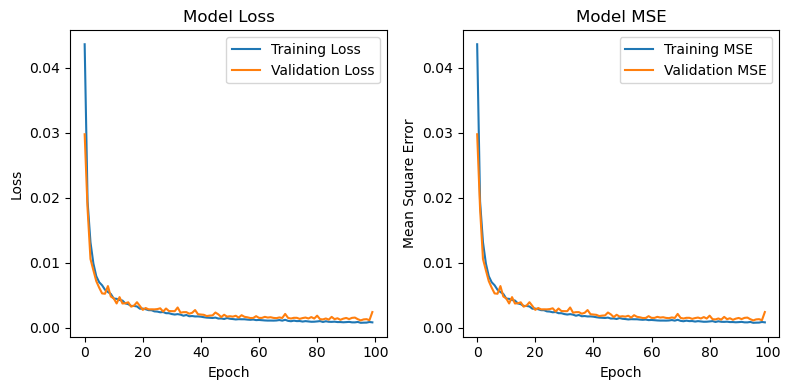

In [49]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
#plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model MSE')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
#plt.grid(True)
plt.tight_layout()

plt.show()

In [47]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

test_dates = test_df['date'].apply(pd.to_datetime)

# Assuming each sequence corresponds to a prediction for the last day in the sequence
# And you have an array or list of indices for your test sequences
prediction_dates = test_dates.iloc[sequence_length:].reset_index(drop=True)

248/248 [==============================] - 0s 2ms/step
MSE: 0.017625387696770464


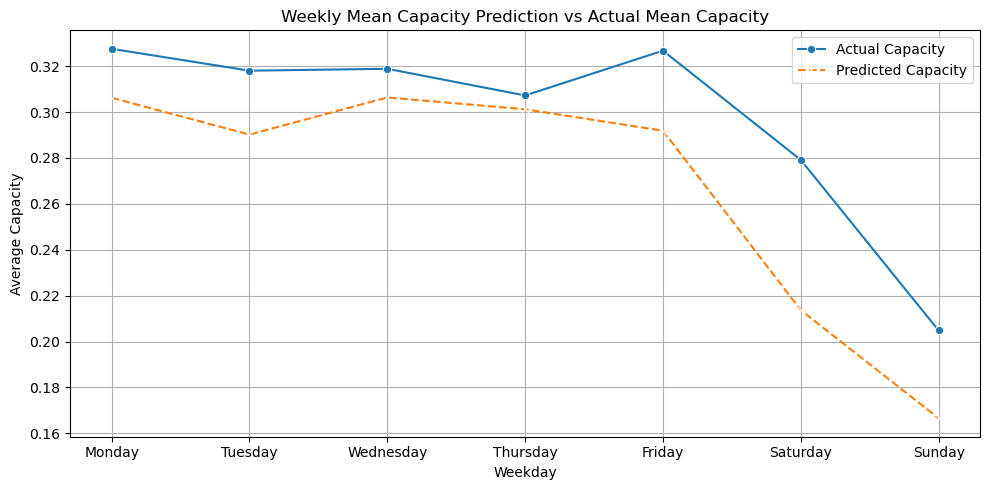

In [51]:
predictions_df = pd.DataFrame({
    'Date': prediction_dates,
    'Actual': y_test.flatten(),  # Flatten if necessary
    'Predicted': predictions.flatten()  # Assuming predictions is your model's output
})

# Calculate the weekday name for each date in the prediction DataFrame
predictions_df['Weekday_Name'] = predictions_df['Date'].apply(lambda x: x.strftime('%A'))

# Aggregate the data by weekday
# You might want to calculate the mean/median/sum of the actual and predicted capacities
weekly_actual = predictions_df.groupby('Weekday_Name')['Actual'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekly_predicted = predictions_df.groupby('Weekday_Name')['Predicted'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=weekly_actual, marker='o', label='Actual Capacity', linestyle='-')
sns.lineplot(data=weekly_predicted, marker='x', label='Predicted Capacity', linestyle='--')

plt.title('Weekly Mean Capacity Prediction vs Actual Mean Capacity')
plt.xlabel('Weekday')
plt.ylabel('Average Capacity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
predictions_df.dtypes

Date            datetime64[ns]
Actual                 float64
Predicted              float32
Weekday_Name            object
dtype: object

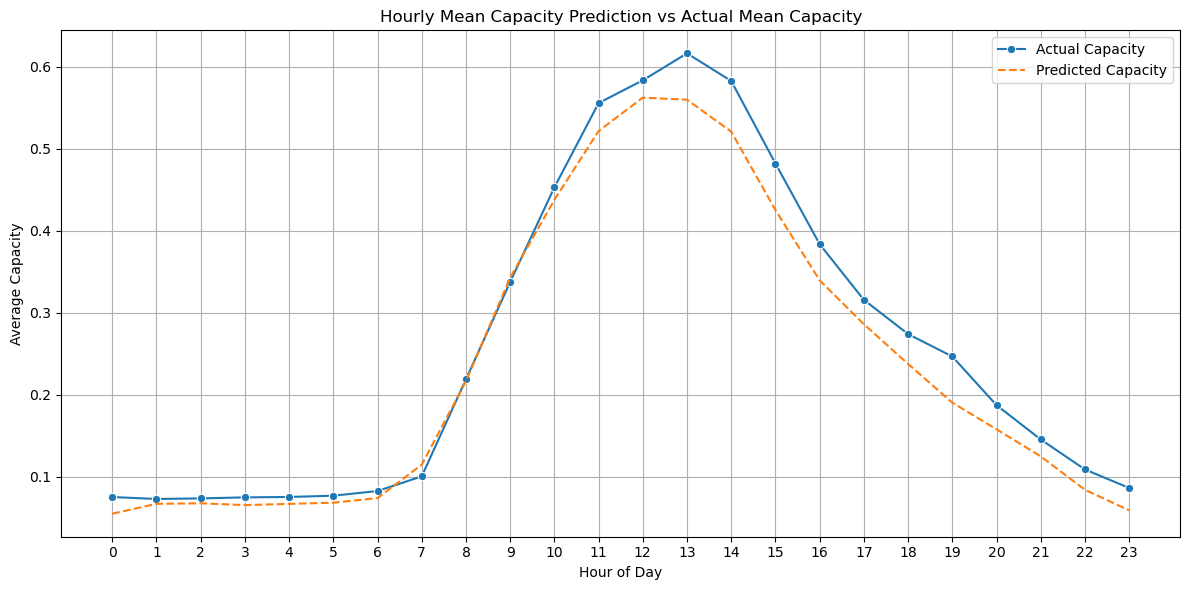

In [53]:
# Assuming 'hour_of_day' is a column in 'test_df' containing integer values of hours
# You don't need to convert it to datetime, just use it directly
prediction_hours = test_df['hour_of_day'].iloc[sequence_length:].reset_index(drop=True)

# Creating the DataFrame
hours_df = pd.DataFrame({
    'Hour': prediction_hours,  # Directly use the hour value
    'Actual': y_test.flatten(),
    'Predicted': predictions.flatten()
})

# Aggregate the data by hour of the day
hourly_actual = hours_df.groupby('Hour')['Actual'].median()
hourly_predicted = hours_df.groupby('Hour')['Predicted'].median()

# Plotting
plt.figure(figsize=(12, 6))  # You can adjust the size here as needed
sns.lineplot(data=hourly_actual, marker='o', label='Actual Capacity', linestyle='-')
sns.lineplot(data=hourly_predicted, label='Predicted Capacity', linestyle='--')
plt.xticks(range(0, 24))  # This sets the ticks from 0 to 23 for 24 hours

plt.title('Hourly Mean Capacity Prediction vs Actual Mean Capacity')
plt.xlabel('Hour of Day')
plt.ylabel('Average Capacity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
